WIP solution guide for w1d4 by Chris MacLeod

In [6]:
import einops
import matplotlib.pyplot as plt
import torch
import tqdm.notebook
from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms
import pandas as pd
from dataclasses import dataclass
from torch import nn
from typing import Callable

plt.rcParams["figure.figsize"] = (12, 12)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
model = models.resnet34(pretrained=True)
model.eval()
model.to(DEVICE)

def imshow(img, fig=None):
    if fig is None:
        fig, ax = plt.subplots()
    if len(img.shape) == 4:
        img = img.squeeze(0)
    img_reshaped = einops.rearrange(img, 'c h w -> h w c')
    # CM: why do we need detach here?
    ax.imshow(img_reshaped.detach())
    ax.set(xticks=[], yticks=[])


cuda:0


In [7]:
# TODO: don't have this on GPU in the first place
# Time permitting students could form the decorrelation matrix themselves
# instead of having magic numbers
examples = torch.load('imagenet-batch.pt', map_location=torch.device('cpu'))
# Exercise: which channels are red, green, and blue? Verify visually.
#examples[:, 0:2] = 0
imshow(make_grid(examples[:10], nrow=5))

In [58]:
equal_power_scaler()[:5,:5]

tensor([[224.0000, 113.0000,  56.5000,  37.6667,  28.2500],
        [224.0000, 100.8895,  54.7842,  37.1452,  28.0280],
        [112.0000,  79.5472,  50.4447,  35.7017,  27.3921],
        [ 74.6667,  62.2955,  45.0548,  33.6298,  26.4221],
        [ 56.0000,  50.1764,  39.7736,  31.2544,  25.2224]])

In [62]:
imagenet_scaler[0, :5, :5]

tensor([[24487.3207, 10046.5304,  5341.3521,  3574.5472,  2680.1869],
        [12626.1703,  5950.8779,  3674.4049,  2625.0684,  1997.9772],
        [ 6722.9540,  3744.2286,  2631.8052,  1996.4667,  1591.1073],
        [ 4345.0847,  2657.5463,  1990.6164,  1582.8242,  1309.4552],
        [ 3251.1642,  2018.8074,  1566.9626,  1309.3905,  1093.5922]],
       dtype=torch.float64)

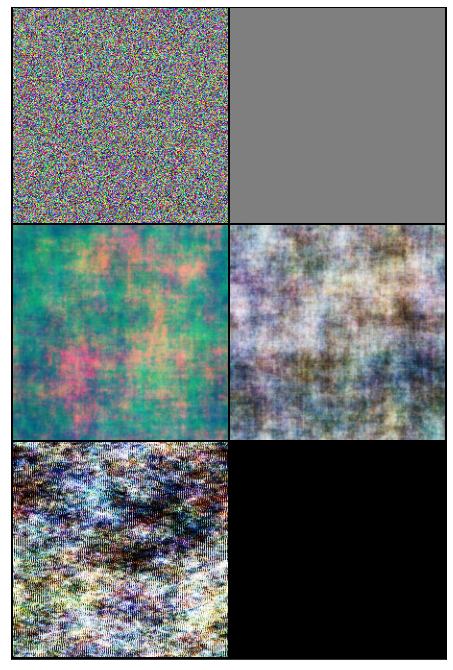

In [75]:


@dataclass
class Experiment:
    param_fn: Callable[[], torch.Tensor]
    layers: nn.Sequential() = nn.Sequential()
    transforms: nn.Sequential() = nn.Sequential()

H = 224
W = 224
TARGET_LOGIT = 50
IMAGE_SHAPE = (1, 3, H, W)
imagenet_scaler = torch.load('result.pt')

def random_spectra(init_sd=1):
    return torch.view_as_complex(init_sd * torch.randn((1, 3, H, (W+1)//2 + 1, 2)))


def equal_power_scaler():
    h_freq = torch.fft.fftfreq(H)[:, None] 
    w_freq = torch.fft.fftfreq((W+1) // 2 + 1)
    freq = (h_freq**2 + w_freq**2).sqrt()
    freq[0,0] = 1 / max(W, H)
    scale = 1.0 / freq
    return scale


class SpectraToImage(nn.Module):
    def __init__(self, scale=None):
        super().__init__()
        self.scale = scale

    def forward(self, spectra):
        if self.scale is not None:
            spectra = spectra * self.scale
        return torch.fft.irfft2(spectra, s=(H, W)).float()


class LinearDecorrelateColor(nn.Module):
    def __init__(self):
        super().__init__()
        color_correlation_svd_sqrt = torch.tensor(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]], dtype=torch.float32)
        max_norm_svd_sqrt = torch.max(torch.linalg.norm(color_correlation_svd_sqrt, axis=0))
        self.mat = color_correlation_svd_sqrt / max_norm_svd_sqrt

    def __call__(self, x):
        return torch.einsum('...khw,kc->...chw', x, self.mat)


class LinearDecorrelateColorSwap(nn.Module):
    def __init__(self):
        super().__init__()
        color_correlation_svd_sqrt = torch.tensor(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]], dtype=torch.float32)
        max_norm_svd_sqrt = torch.max(torch.linalg.norm(color_correlation_svd_sqrt, axis=0))
        self.mat = color_correlation_svd_sqrt / max_norm_svd_sqrt

    def __call__(self, x):
        #print('Multiplying by mat: ', self.mat)
        return torch.einsum('...khw,ck->...chw', x, self.mat)


UniformRandom = Experiment(
    param_fn = lambda: torch.rand(IMAGE_SHAPE),
)
NormalRandom = Experiment(
    param_fn = lambda: 0.01 * torch.randn(IMAGE_SHAPE),
    layers = nn.Sequential(nn.Sigmoid()),
)

Everything = Experiment(
    param_fn = random_spectra,
    layers = nn.Sequential(
            SpectraToImage(imagenet_scaler),
            LinearDecorrelateColor(),
            nn.Sigmoid(),
    ),
    transforms = nn.Sequential(
        transforms.Pad(12, fill=0.5),
        transforms.RandomAffine(
            degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)
        ),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        transforms.RandomCrop((H, W))
    ),
)

Everything2 = Experiment(
    param_fn = random_spectra,
    layers = nn.Sequential(
            SpectraToImage(imagenet_scaler),
            LinearDecorrelateColorSwap(),
            nn.Sigmoid(),
    ),
    transforms = nn.Sequential(
        transforms.Pad(12, fill=0.5),
        transforms.RandomAffine(
            degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)
        ),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        transforms.RandomCrop((H, W))
    ),
)

Everything3 = Experiment(
    param_fn = random_spectra,
    layers = nn.Sequential(
            # Seems pretty arbitrary!
            SpectraToImage(100 * equal_power_scaler()),
            LinearDecorrelateColorSwap(),
            nn.Sigmoid(),
    ),
    transforms = nn.Sequential(
        transforms.Pad(12, fill=0.5),
        transforms.RandomAffine(
            degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)
        ),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        transforms.RandomCrop((H, W))
    ),
)

# Q: can you copy or deepcopy these?


experiments = [
    UniformRandom,
    NormalRandom,
    Everything,
    Everything2,
    Everything3
]

def show_images(params=None):
    if params is None:
        params = [e.param_fn() for e in experiments]
    pixels = torch.concat([e.layers(p) for e, p in zip(experiments, params)])
    imshow(make_grid(pixels, nrow=2))

show_images()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


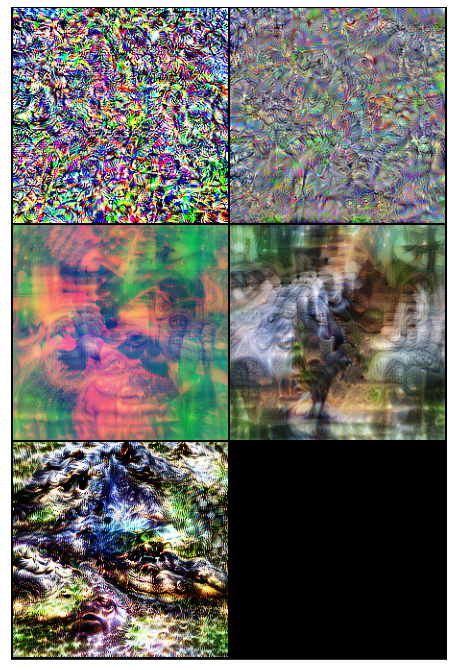

In [76]:
n_iterations = 512
model.requires_grad_(False)

params = [e.param_fn().requires_grad_(True) for e in experiments]
optim = torch.optim.Adam(params, lr=0.05)
all_images = torch.zeros((n_iterations, len(experiments), 3, 224, 224), dtype=torch.float32)
all_losses = torch.zeros((n_iterations, len(experiments)), dtype=torch.float32)

for i in tqdm.notebook.trange(n_iterations):
    optim.zero_grad()
    pixels = [e.layers(param) for param, e in zip(params, experiments)]
    batch = torch.concat([e.transforms(p) for p, e in zip(pixels, experiments)]).to(DEVICE) 
    logits = model(batch)
    
    loss = -logits[:, TARGET_LOGIT]
    loss.sum().backward()
    optim.step()
    all_images[i] = torch.concat(pixels).detach()
    all_losses[i] = loss.detach()
    
show_images(params)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


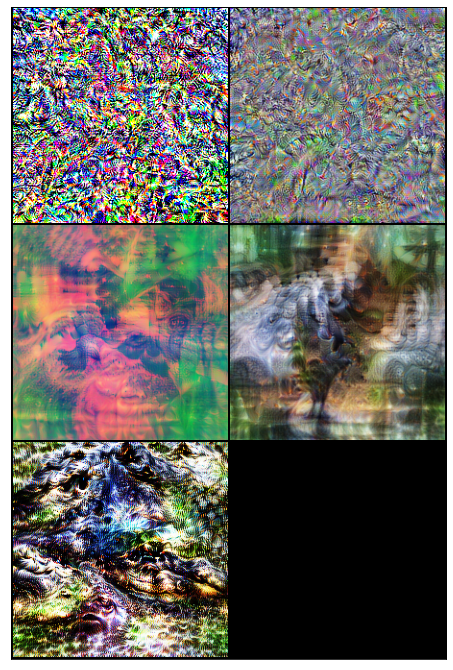

In [77]:
imshow(make_grid(all_images[-1], nrow=2))

interactive(children=(IntSlider(value=0, description='iteration_num', max=511), Output()), _dom_classes=('widg…

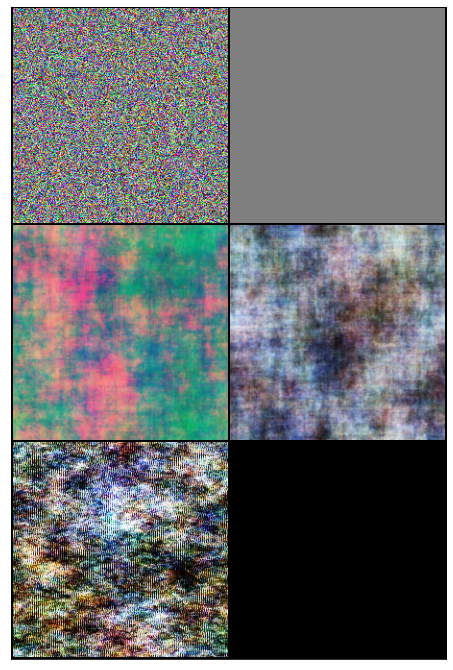

In [78]:
from ipywidgets import widgets, interact

def show_iteration(iteration_num):
    imshow(make_grid(all_images[iteration_num], nrow=2))

interact(show_iteration, 
    iteration_num=widgets.IntSlider(
    value=0,
    min=0,
    max=n_iterations-1,
    step=1
));

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Activation')]

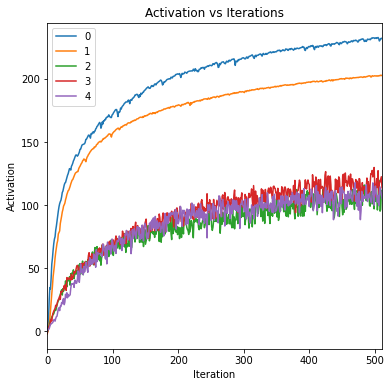

In [79]:
df = pd.DataFrame(-all_losses.numpy())
ax = df.plot(title='Activation vs Iterations', figsize=(6,6))
ax.set(xlabel='Iteration', ylabel='Activation')

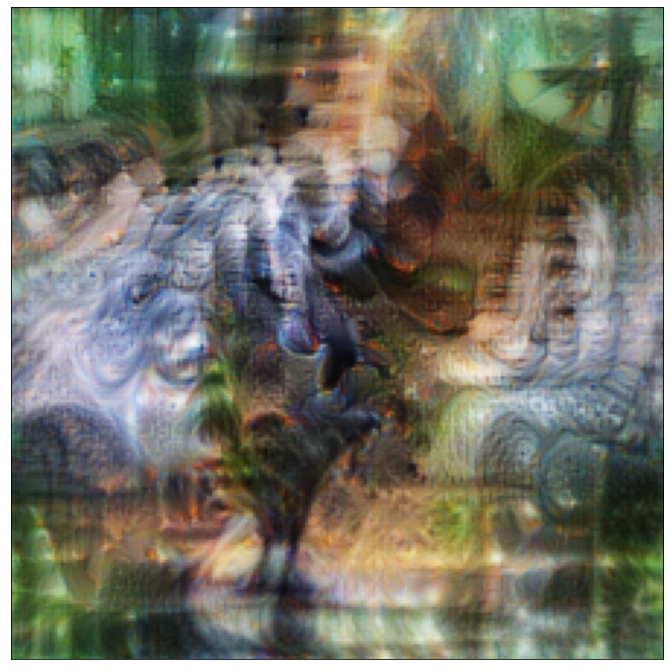

In [82]:
imshow(all_images[-1,-2])

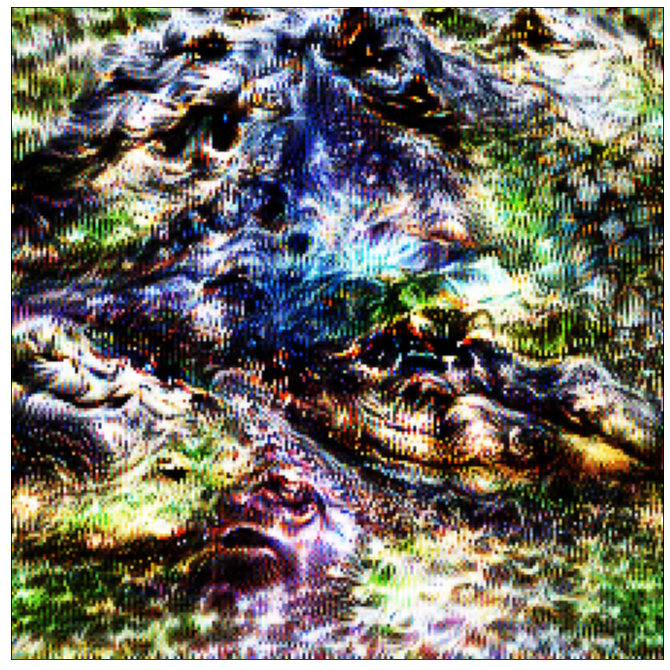

In [80]:
imshow(all_images[-1,-1])